In [ ]:
# https://www.kaggle.com/code/adityataparia/yolo-v3-object-detector

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import math
from collections import Counter

# utils.py

In [3]:
def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def iou(boxes_preds, boxes_labels, box_format="midpoint", iou_mode = "IoU", eps = 1e-7):
    """
    iou Reference:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # mid_x - width/2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # mid_y - height/2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # mid_x + width/2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # mid_y + height/2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2


    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]  # 굳이 0:1로 하는 이유는 차원을 유지하기 위해서다.
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # width, height of predict and ground truth box
    w1, h1 = box1_x2 - box1_x1, box1_y2 - box1_y1 + eps
    w2, h2 = box2_x2 - box2_x1, box2_y2 - box2_y1 + eps

    # coordinates for intersection
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # width, height of convex(smallest enclosing box)
    C_w = torch.max(box1_x2, box2_x2) - torch.min(box1_x1, box2_x1)
    C_h = torch.max(box1_y2, box2_y2) - torch.min(box1_y1, box2_y1)

    # convex diagonal squared
    c2 = C_w**2 + C_h**2 + eps

    # center distance squared
    p2 = ((box2_x1 + box2_x2 - box1_x1 - box1_x2)**2 + (box2_y1 + box2_y2 - box1_y1 - box1_y2)**2) / 4

    # iou
    box1_area = abs(w1 * h1)
    box2_area = abs(w2 * h2)
    union = box1_area + box2_area - intersection + eps

    iou = intersection / union

    if iou_mode == "GIoU":
        C = abs(C_w * C_h) + eps
        B = abs(w1 * h1)
        B_gt = abs(w2 * h2)

        R_giou = abs(C - (B + B_gt - intersection)) / abs(C)

        return iou - R_giou

    elif iou_mode == "DIoU":
        R_diou = p2 / c2

        return iou - R_diou

    elif iou_mode == "CIoU":
        v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
        with torch.no_grad():
            alpha = v / ((1 - iou) + v + eps)

        R_ciou = p2 / c2 + v * alpha

        return iou - R_ciou

    else:
        return iou
    
    

def nms(bboxes, iou_threshold, threshold, box_format='midpoint', iou_mode = "IoU"):


    assert type(bboxes) == list


    bboxes = [box for box in bboxes if box[1] > threshold]

    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nmn = []

    while bboxes:

        chosen_box = bboxes.pop(0)

        
        bboxes = [box for box in bboxes if box[0] != chosen_box[0] 
               or iou(torch.tensor(chosen_box[2:]),
                      torch.tensor(box[2:]),
                      box_format=box_format,
                      iou_mode=iou_mode
                     ) < iou_threshold]
        # bboxes = [box for box in bboxes if box[0] != chosen_box[0]]

        bboxes_after_nmn.append(chosen_box)

    return bboxes_after_nmn




# 이미지 크기의 몇 퍼센트 지점에 x, y 좌표가 있고, 이미지 크기의 몇 퍼센트의 크기로 w, h가 있는지를 반환하는 함수
# grid-relative values to image-relative values
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates

    [objectness, x, y, w, h, class_num] -> [best_class, objectness, x, y, w, h]
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])

        # predictions[..., 5:]는 각 클래스에 대한 예측 확률 값이고 여기에 argmax를 취하여 모델이 예측한 class 중 가장 확률이 높은 것을 뽑아낸다.
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) # predictions[..., 5:] 어떤 식인지 출력해보기
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = PASCAL_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        
        if int(class_pred) > 19:
            class_pred = 0
        
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)] + " " + str(round(box[1], 2)),
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()

    

def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
):
    # make sure model is in eval before get bboxes
    model.eval() # no gradients are computed during evaluation mode
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i): # box is tensor of [class_pred, prob_score, x1, y1, x2, y2]
                bboxes[idx] += box # 디버깅 필요!! box가 어케 +=으로 들어가는지 확인해야 함

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = nms(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


    
def mAP(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20, iou_mode = "IoU"):
    """
    mAP reference:
    https://www.youtube.com/watch?v=FppOzcDvaDI
    https://ctkim.tistory.com/entry/mAPMean-Average-Precision-%EC%A0%95%EB%A6%AC

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
            specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold : Defaultly for mAP @ 50 IoU


    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # img 0 has 3 bboxes
        # img 1 has 5 bboxes
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # amount_bboxes = {0:torch.tensor([0,0,0]), 1:torch.tensor([0,0,0,0,0])}
        detections.sort(key=lambda x : x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iouu = iou(torch.tensor(detection[3:]),
                          torch.tensor(gt[3:]),
                          box_format=box_format,
                          iou_mode = iou_mode)

                if iouu > best_iou:
                    best_iou = iouu
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        recalls = torch.cat((torch.tensor([0]), recalls))       # x axis
        precisions = torch.cat((torch.tensor([1]), precisions)) # y axis
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)
    

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr    



Using **[..., 0:1]** instead of **[..., 0]** in PyTorch is a way to ensure that the result maintains a specific shape. Let me explain:

1. **Maintaining Dimension:**  
When you use **[..., 0:1]**, it selects the values along the last dimension (similar to **[..., 0]**), but it keeps the dimensionality intact. The resulting tensor will have an additional dimension compared to using **[..., 0]**.

2. **Broadcasting:**  
In many PyTorch operations, broadcasting is used to perform operations on tensors with different shapes. Adding a singleton dimension (e.g., using **[..., 0:1]**) can be useful to align dimensions for broadcasting.

3. **Consistency:**  
Using **[..., 0:1]** can be a design choice for consistency in handling dimensions. It makes sure that even if the selected range is a single value (width or height), the result is still a 2D tensor.

4. **Compatibility:**  
Some operations in PyTorch might expect a certain dimensionality for consistent processing. Using **[..., 0:1]** ensures that the tensor shape is consistent across different scenarios.

```py
import torch

# Example tensor
tensor_example = torch.tensor([[1, 2, 3],
                               [4, 5, 6]])

# Using [..., 0:1] to keep dimensionality intact
result_with_0_1 = tensor_example[..., 0:1]

# Using [..., 0] without keeping dimensionality
result_with_0 = tensor_example[..., 0]

print("Result with [..., 0:1]:")
print(result_with_0_1)
print("Shape:", result_with_0_1.shape)

print("\nResult with [..., 0]:")
print(result_with_0)
print("Shape:", result_with_0.shape)
```

### result

```py
Result with [..., 0:1]:
tensor([[1],
        [4]])
Shape: torch.Size([2, 1])

Result with [..., 0]:
tensor([1, 4])
Shape: torch.Size([2])
```

# iou_width_height
 iou_width_height function is designed to handle batched input, where each input tensor (boxes1 and boxes2) can represent multiple bounding boxes.

 In PyTorch, when you perform element-wise operations on tensors with broadcasting, the operation is automatically applied to all corresponding elements of the tensors. Broadcasting allows operations to be performed on tensors of different shapes, and PyTorch automatically adjusts the dimensions to make the operation valid.

In the context of the iou_width_height function:
- If boxes1 and boxes2 are single bounding boxes (i.e., 1D tensors of shape [2]), the operation will be applied element-wise, and you will get a single IoU value.

- If boxes1 and boxes2 are batched bounding boxes (i.e., 2D tensors of shape [batch_size, 2]), the operation will be applied independently for each pair of bounding boxes, and you will get a batch of IoU values.

Here's an example to illustrate:


```py
# iou_width_height Example
import torch

# Example values for box[2:4] and anchors
box_dimensions = torch.tensor([20.0, 30.0])  # Assuming width and height of the box
anchors = torch.tensor([[10.0, 20.0], [25.0, 35.0], [15.0, 25.0]])  # Example set of anchors

# Calculate IoU using the provided function
iou_result = iou_width_height(box_dimensions, anchors)

# Print the result
print("IoU Result:")
print(iou_result)
```

### result

```py
IoU Result:
tensor([0.3333, 0.6857, 0.6250])
```

# IoU, GIoU, DIoU, CIoU Loss Example

```py
import torch
import math

# Assuming your IoU function is defined here...

# Example 1: IoU Calculation
box_preds_iou = torch.tensor([[2.0, 2.0, 4.5, 7.0]])  # (x, y, width, height)
box_labels_iou = torch.tensor([[3.0, 3.0, 4.0, 8.0]])  # (x, y, width, height)

iou_result = IoU(box_preds_iou, box_labels_iou, box_format="midpoint", iou_mode="IoU")
print("IoU Loss:", 1- iou_result.item())

# Example 2: GIoU Calculation

giou_result = IoU(box_preds_iou, box_labels_iou, box_format="midpoint", iou_mode="GIoU")
print("GIoU Loss:", 1 - giou_result.item())

# Example 3: DIoU Calculation


diou_result = IoU(box_preds_iou, box_labels_iou, box_format="midpoint", iou_mode="DIoU")
print("DIoU Loss:", 1 - diou_result.item())

# Example 4: CIoU Calculation


ciou_result = IoU(box_preds_iou, box_labels_iou, box_format="midpoint", iou_mode="CIoU")
print("CIoU Loss:", 1- ciou_result.item())
```

### result

```py
IoU Loss: 0.501474916934967
GIoU Loss: 0.5518950819969177
DIoU Loss: 0.5215124785900116
CIoU Loss: 0.5215561389923096
```

# cells_to_bboxes
## cell_indices
1. **torch.arange(S):**  
Creates a 1D tensor with values from 0 to S-1. This tensor represents indices along one dimension of the image.

2. **.repeat(predictions.shape[0], 3, S, 1):**  
Repeats the 1D tensor **S** times along the last dimension, **3** times along the second-to-last dimension, and **predictions.shape[0]** times along the first dimension. This effectively creates a tensor of shape **(predictions.shape[0], 3, S, S, 1)**.

3. **.unsqueeze(-1):**  
Adds a new dimension at the end of the tensor. The resulting shape is now **(predictions.shape[0], 3, S, S, 1, 1)**.

4. **.to(predictions.device):**  
Moves the tensor to the same device as the **predictions** tensor.
Now, **cell_indices** is a tensor that represents the indices of the cells in the image grid.

5. **x = 1 / S * (box_predictions[..., 0:1] + cell_indices):**  
Calculates the x-coordinate of the bounding boxes. It adds the predicted x-coordinate (normalized between 0 and 1) to the cell indices and scales the result by **1/S**. This effectively maps the x-coordinate prediction to the entire width of the image.

6. **y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4)):**  
Calculates the y-coordinate of the bounding boxes. It adds the predicted y-coordinate (normalized between 0 and 1) to the transposed cell indices and scales the result by **1/S**. The transposition is done to match the dimensions correctly.

7. **w_h = 1 / S * box_predictions[..., 2:4]:**  
Calculates the width and height of the bounding boxes. It scales the predicted width and height (which are already normalized between 0 and 1) by **1/S**.


```py
# example of cell_indices
cell_indices = torch.tensor([[[[[0], [1], [2], [3]],
                               [[0], [1], [2], [3]],
                               [[0], [1], [2], [3]],
                               [[0], [1], [2], [3]]]]])


```

y-coordinate를 구할 때 permute를 하는 이유는 x-coordinate를 구할 때는 위 cell_indices배열 기준으로 0열부터 3열까지 x값이 0부터 3으로 커져야 하지만 y-coordinate를 구할 때는 반대로 0행부터 3행까지 y값이 0부터 3으로 커져야 하기 때문에 permute를 통해 행과 열을 전치시켜주는 것이다.

# get_evaluation_bboxes
**boxes_scale_i** has the shape **(BATCH_SIZE, num_anchors * S * S, 6)**, so each element in the loop represents a tensor of shape **(num_anchors * S * S, 6)**.

```py
# Assuming boxes_scale_i has the shape (BATCH_SIZE, num_anchors * S * S, 6)
boxes_scale_i = torch.tensor([
    # ... Example values with shape (num_anchors * S * S, 6)
])

# Initialize an empty list to store bounding boxes for each image in the batch
bboxes = [[] for _ in range(boxes_scale_i.shape[0])]

# Iterate over predicted bounding boxes and append them to the corresponding image's list
for idx, (box) in enumerate(boxes_scale_i):
    bboxes[idx] += box
```

In this context:

- **boxes_scale_i.shape[0]** is **BATCH_SIZE**, representing the number of images in the batch.
- Each **box** during the loop iteration is a tensor of shape **(num_anchors * S * S, 6)** representing bounding boxes for a specific image.

After the loop, **bboxes** will be a list of lists, where each inner list corresponds to a set of bounding boxes for a specific image:

```py
bboxes = [
    # Image 1 bounding boxes with shape (num_anchors * S * S, 6)
    # Image 2 bounding boxes with shape (num_anchors * S * S, 6)
    # ... and so on for each image in the batch
]
```

Up to the above code is the result of one scale, and since it is repeated (three times) for all scales, the total number of bounding boxes per image in the **bboxes** becomes **(3 * num_anchors * S * S, 6)**, and only significant boxes are left by applying NMS to these boxes.


# config.py

In [4]:
DATASET = 'PASCAL_VOC'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


BATCH_SIZE = 32
IMAGE_SIZE = 416
NUM_CLASSES = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 10
CONF_THRESHOLD = 0.2
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
LOAD_MODEL = False
SAVE_MODEL = True

# CHECKPOINT_FILE = "checkpoint.pth.tar"
CHECKPOINT_FILE = "/kaggle/working/checkpoint.pth.tar"

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]


train_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        # Random color jittering
        A.ColorJitter(
            brightness=0.5, contrast=0.5,
            saturation=0.5, hue=0.5, p=0.5
        ),
        # Flip the image horizontally
        A.HorizontalFlip(p=0.5),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ], 
    # Augmentation for bounding boxes
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)

# Transform for testing
test_transform = A.Compose(
    [
        # Rescale an image so that maximum side is equal to image_size
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        # Pad remaining areas with zeros
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        # Normalize the image
        A.Normalize(
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ),
        # Convert the image to PyTorch tensor
        ToTensorV2()
    ],
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams(
                    format="yolo", 
                    min_visibility=0.4, 
                    label_fields=[]
                )
)


PASCAL_CLASSES = [
    "airplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]



# dataset.py

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
[[12.0, 1.0, 0.43000003695487976, 0.4977976679801941, 0.5120000243186951, 0.6622808575630188], [12.0, 1.0, 0.43000003695487976, 0.4977976679801941, 0.5120000243186951, 0.6622808575630188], [12.0, 1.0, 0.43000003695487976, 0.4977976679801941, 0.5120000243186951, 0.6622808575630188]]


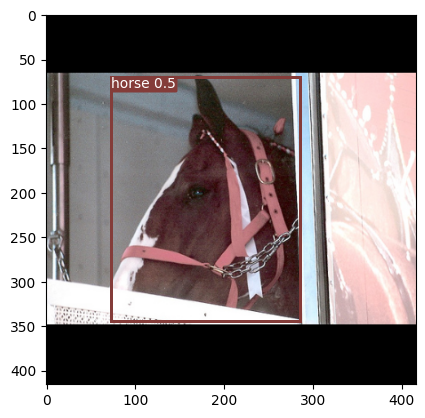

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
[[5.0, 1.0, 0.1380000114440918, 0.4670000374317169, 0.2199999988079071, 0.12800000607967377], [5.0, 1.0, 0.3569999933242798, 0.5220000147819519, 0.21000000834465027, 0.2540000081062317], [6.0, 1.0, 0.2370000183582306, 0.6010000109672546, 0.12200000137090683, 0.14800000190734863], [14.0, 1.0, 0.4520000219345093, 0.5970000624656677, 0.0560000017285347, 0.1680000126361847], [14.0, 1.0, 0.5, 0.6069999933242798, 0.052000001072883606, 0.14400000870227814], [14.0, 1.0, 0.5740000009536743, 0.5840000510215759, 0.06400000303983688, 0.15400001406669617], [6.0, 1.0, 0.09600000828504562, 0.6620000004768372, 0.19200001657009125, 0.27000001072883606], [14.0, 1.0, 0.6539999842643738, 0.6190000176429749, 0.11999999731779099, 0.29600000381469727], [14.0, 1.0, 0.7450000643730164, 0.6460000276565552, 0.0820000022649765, 0.2460000067949295], [14.0, 1.0, 0.

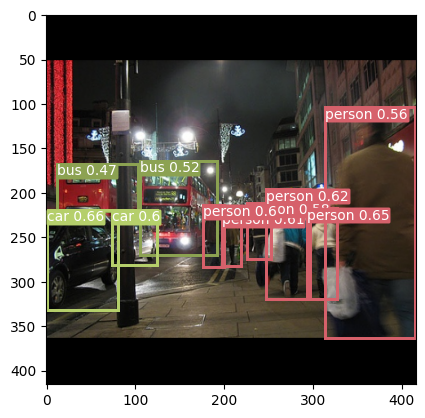

torch.Size([3, 2])
torch.Size([1, 3, 13, 13, 6])
torch.Size([3, 2])
torch.Size([1, 3, 26, 26, 6])
torch.Size([3, 2])
torch.Size([1, 3, 52, 52, 6])
10647
[[14.0, 1.0, 0.4449999928474426, 0.4710000157356262, 0.1860000044107437, 0.35600000619888306], [4.0, 1.0, 0.4650000333786011, 0.5200000405311584, 0.04200000315904617, 0.0820000022649765], [4.0, 1.0, 0.51500004529953, 0.6450000405311584, 0.09400000423192978, 0.18400000035762787], [4.0, 1.0, 0.8130000233650208, 0.6450000405311584, 0.05000000074505806, 0.09200000017881393], [14.0, 1.0, 0.12600000202655792, 0.5100000500679016, 0.23200000822544098, 0.534000039100647], [14.0, 1.0, 0.29200002551078796, 0.5970000624656677, 0.4480000138282776, 0.5520000457763672], [14.0, 1.0, 0.8160000443458557, 0.5509999990463257, 0.2760000228881836, 0.6439999938011169], [4.0, 1.0, 0.4650000333786011, 0.5200000405311584, 0.04200000315904617, 0.0820000022649765], [4.0, 1.0, 0.51500004529953, 0.6450000405311584, 0.09400000423192978, 0.18400000035762787], [4.0, 1

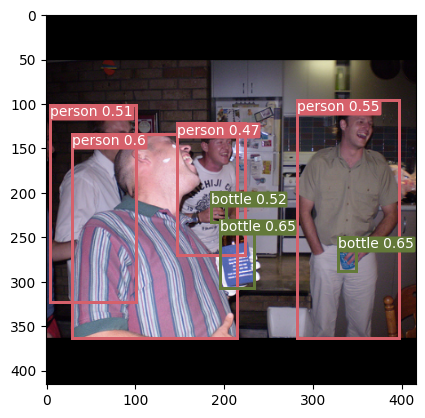

In [5]:
class YOLODataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13,26,52],
        C=20,
        transform=None
        ):

        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2]) # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist() # [class,x,y,w,h] -> [x,y,w,h,class]
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]


        # Ground Truth ..?
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S] # 6 -> [objectness, x, y, w, h, class]

        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False, False, False]

            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale  # scale -> 0, 1, 2
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale # an anchor of particular scale -> 0, 1, 2
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x) # e.g. x = 0.5, S = 13 --> int(6.5) = 6th cell of x
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1 # objectness = 1
                    x_cell, y_cell = S*x - j, S*y - i # both are between [0, 1] e.g. 6.5 - 6 = 0.5

                    width_cell, height_cell = (       # ground truth에 w, h를 log(bw/pw), log(bh/ph)로 넣지 않는 이유..?
                        width * S,  # e.g. S = 13, width = 0.5, 6.5
                        height * S
                    )

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:  # box가 현재 scale_idx에 대한 anchor 할당을 iou가 가장 높은거로 받았으나 각 scale당 3개의 anchor가 존재하므로 iou가 가장 높은거 이외의 것들이 여기로 온다?
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore this predicion

        return image, tuple(targets)
    
    
def test():
    anchors = ANCHORS

    transform = test_transform

    dataset = YOLODataset(
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
        "/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    cnt = 0


    for x, y in loader:
        cnt += 1
        if cnt == 4:
            break

        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print(anchor.shape)
            print(y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print(len(boxes))
        boxes = nms(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


if __name__ == "__main__":
    test()

# model.py

In [6]:
# model.py

import torch
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding, 
            bias=not bn_act, **kwargs
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)
        

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, use_residual=True, repeats=1):
        super().__init__()
        
        res_layers = []
        
        for _ in range(repeats):
            res_layers += [
                nn.Sequential(
                    CNNBlock(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0, bn_act=True), # 1x1 
                    CNNBlock(in_channels//2, in_channels, kernel_size=3, stride=1, padding=1, bn_act=True) # 3x3
                )
            ]
        self.layers = nn.ModuleList(res_layers)
        self.repeats = repeats
        self.use_residual = use_residual
        
    def forward(self, x):
        for layer in self.layers:
            res = x
            x = layer(x)
            if self.use_residual:
                x = x + res  # skip connection
        return x
        

class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.pred = nn.Sequential(
            CNNBlock(in_channels, in_channels*2, kernel_size=3, stride=1, padding=1, bn_act=True),
            # (4 + 1 + num_classes) * 3 : 4 for [x, y, w, h], 1 for objectness prediction, 3 for anchor boxes per grid ce
            CNNBlock(in_channels*2, 3*(4+1+num_classes), kernel_size=1, stride=1, padding=0, bn_act=False)
        )
        self.num_classes =  num_classes
    
    def forward(self, x):
        output = self.pred(x)
        
        # x = [batch_num, 3*(num_classes + 5), N, N]
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        output = output.permute(0, 1, 3, 4, 2) # output = [B x 3 x N x N x 5+num_classes]
        return output 
        

class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels  
        
        self.layers = nn.ModuleList([
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1, bn_act=True), # padding=1 if kernel_size == 3 else 0
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1, bn_act=True),
            ResidualBlock(64, repeats=1),
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1, bn_act=True),
            ResidualBlock(128, repeats=2),
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1, bn_act=True),
            ResidualBlock(256, repeats=8),
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1, bn_act=True),
            ResidualBlock(512, repeats=8),
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1, bn_act=True),
            ResidualBlock(1024, repeats=4), # To this point is Darknet-53
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0, bn_act=True),
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1, bn_act=True),
            ResidualBlock(1024, use_residual=False, repeats=1),
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0, bn_act=True),
            ScalePrediction(512, num_classes=num_classes),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, bn_act=True), # for concatenate
            nn.Upsample(scale_factor=2),
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0, bn_act=True),
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, bn_act=True),
            ResidualBlock(512, use_residual=False, repeats=1),
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, bn_act=True),
            ScalePrediction(256, num_classes=num_classes),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0, bn_act=True), # for concatenate
            nn.Upsample(scale_factor=2),
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0, bn_act=True),
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1, bn_act=True),
            ResidualBlock(256, use_residual=False, repeats=1),
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0, bn_act=True),
            ScalePrediction(128, num_classes=num_classes)
        ])
        
    def forward(self, x):
        outputs = [] # for each scale
        route_connections = [] # for concatenate
        
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue # Since this is the output of each scale, it must skip x = ScalePrediction(x).
            x = layer(x)
            
            if isinstance(layer, ResidualBlock) and layer.repeats == 8:
                route_connections.append(x)
            
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
            
        return outputs

In [7]:
# model test
# import config
num_classes = 20
IMAGE_SIZE = 416
model = YOLOv3(num_classes=num_classes)

x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
out = model(x)
assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
print("Success!")

Success!


# loss.py

In [8]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()


        # constants 
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # predictions -> [objectness, x, y, w, h, class] ..?

        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        
        # No object Loss
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj])
        )

        
        # Object Loss
        anchors = anchors.reshape(1, 3, 1, 1, 2) # 3(anchor) x 2(h, w), p_w * exp(t_w)를 연산하기 위해 reshape
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj])) # target과 iou로 겹치는 정도만 gt로 반영

        
        # Box Coordinate Loss 
        # MSE Loss 
        """
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) # x, y to be between [0, 1]
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])
        """
        
        # IoU, GIoU, DIoU, CIoU Loss
        anchors = anchors.reshape(1, 3, 1, 1, 2) # 3(anchor) x 2(h, w), p_w * exp(t_w)를 연산하기 위해 reshape
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        iou_loss = 1 - iou(boxes_preds=box_preds[obj], boxes_labels=target[..., 1:5][obj], box_format="midpoint", iou_mode = "DIoU")
        # box_loss = sum(iou_loss)/len(iou_loss)
        box_loss = iou_loss.mean()


        # Class Loss
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long())
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

# Implementation of $𝟙^{obj}_ {i j}$ and $𝟙^{noobj}_{i j}$


In the expression **target[..., 1:5][obj]**, the **[obj]** at the end is used for boolean indexing or masking**($𝟙^{obj}_ {i j}$, $𝟙^{noobj}_{i j}$)** . Let's break down the expression to understand it better:

1. **target[..., 1:5]**: This part selects a subarray of the target tensor. Specifically, it selects the elements along the last dimension (index 1 to 4) of the tensor. This is often used in object detection models to extract the predicted bounding box coordinates.

2. **target[..., 0] == 1**: This creates a boolean mask by checking whether the values in the first channel of the last dimension of the **target** tensor are equal to 1. This typically represents the confidence scores for the presence of an object.

3. **target[..., 1:5][obj]**: Finally, the boolean mask **[obj]** is applied to the selected subarray. This means that only the elements corresponding to **True** values in the boolean mask will be returned. In the context of object detection, this operation is likely used to filter out predictions for which the confidence score is not equal to 1 (i.e., where an object is confidently detected).

```py
# Iobj_i, Inoobj_i Example

target = torch.tensor([[[[0, 0.2, 0.5, 0.7, 0.3, 0.9],
                        [1, 0.3, 0.4, 0.6, 0.2, 0.8]],
                       [[0, 0.5, 0.3, 0.6, 0.7, 0.2],
                        [-1, 0.4, 0.7, 0.5, 0.1, 0.6]]]])

obj = target[..., 0] == 1

print(target[..., 0])
print(obj)
print(target[..., 1:5][obj])
print(target[..., 1:5][target[..., 0] == 1]) # Equivalent expressions
```

### result
```py
tensor([[[ 0.,  1.],
         [ 0., -1.]]])
tensor([[[False,  True],
         [False, False]]])
tensor([[0.3000, 0.4000, 0.6000, 0.2000]])
tensor([[0.3000, 0.4000, 0.6000, 0.2000]])
```

# train.py

In [9]:
# Define the train function to train the model
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    # Creating a progress bar
    progress_bar = tqdm(loader, leave=True)

    # Initializing a list to store the losses
    losses = []

    # Iterating over the training data
    for _, (x, y) in enumerate(progress_bar):
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE),
        )

        with torch.cuda.amp.autocast():
            # Getting the model predictions
            outputs = model(x)
            # Calculating the loss at each scale
            loss = (
                  loss_fn(outputs[0], y0, scaled_anchors[0])
                + loss_fn(outputs[1], y1, scaled_anchors[1])
                + loss_fn(outputs[2], y2, scaled_anchors[2])
            )

        # Add the loss to the list
        losses.append(loss.item())

        # Reset gradients
        optimizer.zero_grad()

        # Backpropagate the loss
        scaler.scale(loss).backward()

        # Optimization step
        scaler.step(optimizer)

        # Update the scaler for next iteration
        scaler.update()

        # update progress bar with loss
        mean_loss = sum(losses) / len(losses)
        progress_bar.set_postfix(loss=mean_loss)

In [ ]:
# Creating the model from YOLOv3 class
model = YOLOv3().to(DEVICE)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Defining the loss function
loss_fn = YOLOLoss()

# Defining the scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Defining the train dataset
train_dataset = YOLODataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv",
    img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=train_transform
)

# Defining the train data loader
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 4,
    shuffle = True,
    pin_memory = True,
)

# Scaling the anchors
scaled_anchors = (
    torch.tensor(ANCHORS) * 
    torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
).to(DEVICE)


LOAD_MODEL = False
# Loading the checkpoint 
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_FILE, model, optimizer, LEARNING_RATE)

# Training the model
for e in range(1, EPOCHS+1):
    print("Epoch:", e)
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    # Saving the model
    if SAVE_MODEL:
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


100%|██████████| 518/518 [05:37<00:00,  1.54it/s, loss=41.5]


=> Saving checkpoint
Epoch: 2


100%|██████████| 518/518 [05:32<00:00,  1.56it/s, loss=32.3]


=> Saving checkpoint
Epoch: 3


100%|██████████| 518/518 [05:32<00:00,  1.56it/s, loss=29.5]


=> Saving checkpoint
Epoch: 4


100%|██████████| 518/518 [05:32<00:00,  1.56it/s, loss=27.8]


=> Saving checkpoint
Epoch: 5


 78%|███████▊  | 402/518 [04:18<01:14,  1.55it/s, loss=26.7]

In [ ]:
# Taking a sample image and testing the model

# Setting the load_model to True
LOAD_MODEL = True

# Defining the model, optimizer, loss function and scaler
model = YOLOv3().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YOLOLoss()
scaler = torch.cuda.amp.GradScaler()

# Loading the checkpoint
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_FILE, model, optimizer, LEARNING_RATE)

# Defining the test dataset and data loader
test_dataset = YOLODataset(
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/test.csv",
    img_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images/",
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels/",
    anchors=ANCHORS,
    transform=test_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 4,
    shuffle = True,
)

# Getting a sample image from the test data loader
x, y = next(iter(test_loader))
x = x.to(DEVICE)

model.eval()
with torch.no_grad():
    # Getting the model predictions
    output = model(x)
    # Getting the bounding boxes from the predictions
    bboxes = [[] for _ in range(x.shape[0])]
    anchors = (
            torch.tensor(ANCHORS)
                * torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1,3,2)
            ).to(DEVICE)

    # Getting bounding boxes for each scale
    for i in range(3):
        batch_size, A, S, _, _ = output[i].shape
        anchor = anchors[i]
        boxes_scale_i = cells_to_bboxes(
                            output[i], anchor, S=S, is_preds=True
                        )
        for idx, (box) in enumerate(boxes_scale_i):
            bboxes[idx] += box
model.train()

print(len(bboxes))
# Plotting the image with bounding boxes for each image in the batch
for i in range(BATCH_SIZE):
    # Applying non-max suppression to remove overlapping bounding boxes
    print("bboxes : " + str(len(bboxes[i])))
    nms_boxes = nms(bboxes[i], iou_threshold=0.45, threshold=0.6, iou_mode = "DIoU")
    print("nms_bboxes : " + str(len(nms_boxes)))
    # Plotting the image with bounding boxes
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)
    
    



In [ ]:
# mAP test 
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold=0.45, # NMS_IOU_THRESH
    anchors=ANCHORS,
    threshold=0.5,      # CONF_THRESHOLD
)


In [ ]:
# get_evaluation_bboxes 계속 돌리면 오래걸리니까 따로 여기서 실행 
mapval = mAP(
    pred_boxes,
    true_boxes,
    iou_threshold=MAP_IOU_THRESH,
    box_format="midpoint",
    num_classes=NUM_CLASSES,
)

print(f"MAP: {mapval.item()}")